# EPFL Machine Learning Higgs

## Loading and preprocessing

In [2]:
import math
%load_ext autoreload
%autoreload 2

import os
import csv
import numpy as np
from helpers import load_data, one_hot_encode, standardize

In [4]:
data_directory = '../../data'
train_dataset_path = os.path.join(data_directory, 'train.csv')
public_test_dataset_path = os.path.join(data_directory, 'test.csv')

# Loading the data
_, Y_train_public, feature_names, X_train_public = load_data(train_dataset_path)
ids_test_public, _, _, X_test_public = load_data(public_test_dataset_path)

KeyboardInterrupt: 

In [4]:
# We need to deal with -999 somehow (missing values)
# First of all, we make sure they do not contribute to computing the mean and std
# Since they are floats, we add an epsilon against numerical errors
EPSILON = 1E-4
mask_train = np.abs(X_train_public + 999) <= EPSILON
mask_test = np.abs(X_test_public + 999) <= EPSILON

X_train_public[mask_train] = np.nan
X_test_public[mask_test] = np.nan

print('Proportion of missing values:', np.sum(mask_train)/(mask_train.shape[0]*mask_train.shape[1]))
print('Proportion of missing values:', np.sum(mask_test)/(mask_test.shape[0]*mask_test.shape[1]))

Proportion of missing values: 0.2106736
Proportion of missing values: 0.21050064702935506


In [5]:
# We will standardize the data based on the mean and standard deviation of the public train dataset
# It ignores NaN values for computing the mean and std for the standardization
# ! The method standardizes in-place !
continuous_column_idxs = np.where(feature_names != "PRI_jet_num")[0]
column_means, column_stds = standardize(X_train_public, continuous_column_idxs)
_, _ = standardize(X_test_public, continuous_column_idxs, column_means, column_stds)

# Finally, we set the NaNs to the mean of the standardized dataset, namely, 0
X_train_public = np.nan_to_num(X_train_public, nan=0.0)
X_test_public = np.nan_to_num(X_test_public, nan=0.0)

In [6]:
# Then we will need to notice the discrete-valued column, since this needs to be one-hot encoded
# In our dataset, only "PRI_jet_num" is discrete.
discrete_column_idxs = np.where(feature_names == "PRI_jet_num")[0]

# Update the features by one-hot encoding the discrete ones, but only update the feature names at the end
# They will be the same for the train and test set anyway
X_train_public, _ = one_hot_encode(X_train_public, discrete_column_idxs, feature_names)
X_test_public, feature_names = one_hot_encode(X_test_public, discrete_column_idxs, feature_names)

In [7]:
# Since this is a binary classification problem, we do not need to one-hot encode the y-vector, but we can just use binary values
positive_sample = 's'
negative_sample = 'b'
Y_train_public = np.expand_dims((Y_train_public == positive_sample).astype(np.int32), axis=1)

# ! There are quite some more positive than negative samples, maybe we could try to weigh negative samples more or something? !
print('Number of positive samples:', np.sum(Y_train_public))
print('Number of negative samples:', len(Y_train_public) - np.sum(Y_train_public))

Number of positive samples: 85667
Number of negative samples: 164333


In [8]:
# Just to know the percentage of signal and background events
print(f'''There are a total of {np.sum(Y_train_public)*100/len(Y_train_public):.2f}% signal events and {(len(Y_train_public) - np.sum(Y_train_public))*100/len(Y_train_public):.2f}% background events.''') 

# ZeroR predicts always the majority class, which is background events in this case
print(f'''So, the ZeroR classiffier has an accuracy of {(len(Y_train_public) - np.sum(Y_train_public))*100/len(Y_train_public):.2f}%, which will be the baseline performance as a benchmark for the other classification methods.''')



There are a total of 34.27% signal events and 65.73% background events.
So, the ZeroR classiffier has an accuracy of 65.73%, which will be the baseline performance as a benchmark for the other classification methods.


# Training and analysis

In [9]:
# We will do k-fold cross validation to create subsets of the training and testing datasets
print(feature_names)
print(X_train_public.shape, X_test_public.shape)
print(Y_train_public.shape)

['DER_mass_MMC' 'DER_mass_transverse_met_lep' 'DER_mass_vis' 'DER_pt_h'
 'DER_deltaeta_jet_jet' 'DER_mass_jet_jet' 'DER_prodeta_jet_jet'
 'DER_deltar_tau_lep' 'DER_pt_tot' 'DER_sum_pt' 'DER_pt_ratio_lep_tau'
 'DER_met_phi_centrality' 'DER_lep_eta_centrality' 'PRI_tau_pt'
 'PRI_tau_eta' 'PRI_tau_phi' 'PRI_lep_pt' 'PRI_lep_eta' 'PRI_lep_phi'
 'PRI_met' 'PRI_met_phi' 'PRI_met_sumet' 'PRI_jet_leading_pt'
 'PRI_jet_leading_eta' 'PRI_jet_leading_phi' 'PRI_jet_subleading_pt'
 'PRI_jet_subleading_eta' 'PRI_jet_subleading_phi' 'PRI_jet_all_pt'
 'PRI_jet_num_0' 'PRI_jet_num_1' 'PRI_jet_num_2' 'PRI_jet_num_3']
(250000, 33) (568238, 33)
(250000, 1)


Iteration number 1


100%|██████████| 1000/1000 [00:32<00:00, 30.34it/s]


Iteration number 2


100%|██████████| 1000/1000 [00:33<00:00, 30.23it/s]


Iteration number 3


100%|██████████| 1000/1000 [00:32<00:00, 30.67it/s]


Iteration number 4


100%|██████████| 1000/1000 [00:32<00:00, 30.70it/s]


Iteration number 5


100%|██████████| 1000/1000 [00:32<00:00, 30.67it/s]


Iteration number 6


100%|██████████| 1000/1000 [00:32<00:00, 30.69it/s]


Iteration number 7


100%|██████████| 1000/1000 [00:32<00:00, 30.72it/s]


Iteration number 8


100%|██████████| 1000/1000 [00:32<00:00, 30.71it/s]


Iteration number 9


100%|██████████| 1000/1000 [00:32<00:00, 30.73it/s]


Iteration number 10


100%|██████████| 1000/1000 [00:32<00:00, 30.71it/s]


The best lambda for reg logistic regression is 0.0 with a loss of 0.541550805501868


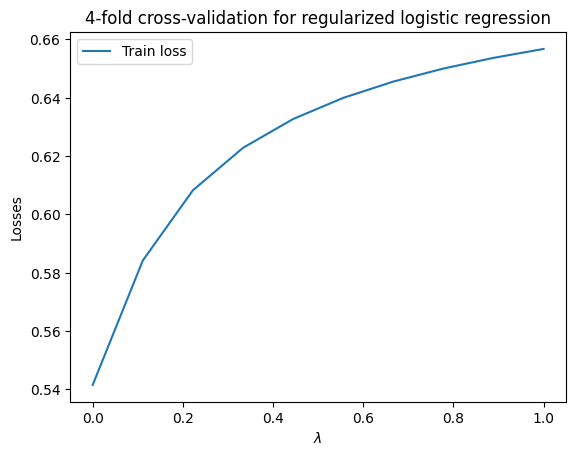

In [11]:
# Best lambda for regularized logistic regression
# 4-fold cross-validation

from helpers import cross_validation_method, build_k_indices, train_test_split
from implementations import reg_logistic_regression
import matplotlib.pyplot as plt 
import seaborn as sns

lambdas = np.linspace(0, 1, 10)
k_fold = 4
k_indices = build_k_indices(X_train_public, Y_train_public, k_fold, 2)

# Variables to store the minimum loss (minLoss), the best lambda (bestLamb) and all losses
minLossrlr = np.inf
bestLambrlr = 0
train_losses_rlr = []
i = 1
# Iterate in lambdas
for lam in lambdas:
    # Losses array that will store the losses of each fold
    loss_tr_lam = []
    max_iterations = 1000
    gamma = 0.01    
    param = {"lambda_": lam, "max_iters": max_iterations, "gamma": gamma}

    # Just to know which iteration is being computed
    print ("Iteration number", i)
    i += 1
    
    # Iterate for each fold in k_folds
    for k in range(k_fold):
        loss_tr_lam = np.append(loss_tr_lam, cross_validation_method(X_train_public, Y_train_public, k_indices, k, reg_logistic_regression, param))
    
    # We store the lam and mean loss
    train_losses_rlr.append(loss_tr_lam.mean())
    
    # If the average loss of said lambda is smaller than our previous loss
    if loss_tr_lam.mean() < minLossrlr:
        # We update the new best loss
        minLossrlr = loss_tr_lam.mean()
        # We store the new best lamda
        bestLambrlr = lam
    

print("The best lambda for reg logistic regression is", bestLambrlr, "with a loss of", minLossrlr)
plt.figure()
ax = sns.lineplot(x=lambdas, y=train_losses_rlr, legend='brief', label='Train loss')
ax.set(xlabel="$\lambda$", ylabel="Losses", title="4-fold cross-validation for regularized logistic regression")
plt.savefig( '../visualizations/cross-validation/4-fold-cv-reg_log_reg.png', dpi=500, bbox_inches='tight')
plt.show()


The best lambda for ridge regression is 0.0 with a loss of 0.08448650307725179


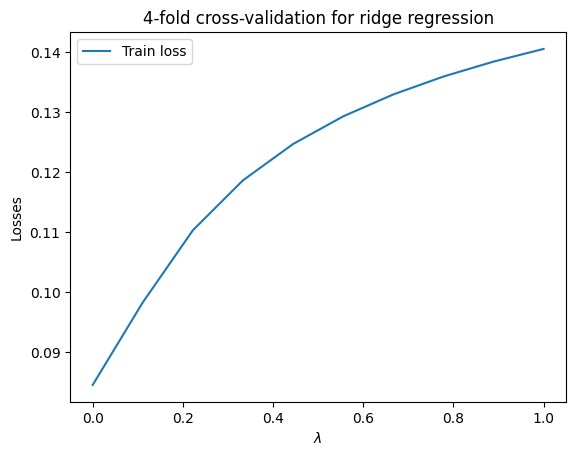

In [90]:
# Best lambda for reg logistic regression
# 4-fold cross validation

from implementations import ridge_regression

lambdas = np.linspace(0, 1, 10)
k_fold = 4
k_indices = build_k_indices(X_train_public, Y_train_public, k_fold, 2)

# Variables to store the minimum loss (minLoss), the best lambda (bestLamb) and all losses
minLossrr = np.inf
bestLambrr = 0
train_losses_rr = []
# Iterate in lambdas
for lam in lambdas:
    # Losses array that will store the losses of each fold
    loss_tr_lam = []
    param = {"lambda_": lam}

    # Iterate for each fold in k_folds
    for k in range(k_fold):
        loss_tr_lam = np.append(loss_tr_lam, cross_validation_method(X_train_public, Y_train_public, k_indices, k, ridge_regression, param))
    
    # We store the lam and mean loss
    train_losses_rr.append(loss_tr_lam.mean())
    # If the average loss of said lambda is smaller than our previous loss
    if loss_tr_lam.mean() < minLossrr:
        # We update the new best loss
        minLossrr = loss_tr_lam.mean()
        # We store the new best lamda
        bestLambrr = lam

print("The best lambda for ridge regression is", bestLambrr, "with a loss of", minLossrr)

plt.figure()
ax = sns.lineplot(x=lambdas, y=train_losses_rr, legend='brief', label='Train loss')
ax.set(xlabel="$\lambda$", ylabel="Losses", title="4-fold cross-validation for ridge regression")
plt.savefig( '../visualizations/cross-validation/4-fold-cv-rid_reg.png', dpi=500, bbox_inches='tight')
plt.show()

In [25]:
from helpers import train_test_split
from implementations import reg_logistic_regression_AGDR, reg_logistic_regression
from metrics import confusion_matrix_statistics, LogisticRegressionLoss

import seaborn as sns
import matplotlib.pyplot as plt

X_train, X_test, Y_train, Y_test = train_test_split(X_train_public, Y_train_public, train_proportion=0.8)

print('Number of positive samples in test set:', np.sum(Y_test))
print('Number of negative samples in test set:', len(Y_test) - np.sum(Y_test))

max_iterations = 200
gamma = 0.1

Number of positive samples in test set: 17282
Number of negative samples in test set: 32718


In [ ]:
# Here we will experiment the performance using different interaction terms added to the model
# We will add interaction terms to deal with co-linearity (adding feature x1*x2 instead of just x1 and x2)

from helpers import get_interaction_terms_columns, add_interaction_terms_columns

num_thresholds_tested = 10
# Creates constant intervals between [0, 1]
co_linear_thresholds = [round(1 - i/num_thresholds_tested, 5) for i in range(num_thresholds_tested+1)]

train_losses = []
test_losses = []

for co_linear_threshold in co_linear_thresholds:
    co_linear_feature_columns = get_interaction_terms_columns(X_train_public, co_linear_threshold=co_linear_threshold)

    print('We have found', len(co_linear_feature_columns), 'interaction terms with at least that correlation')

    tmp_X_train = add_interaction_terms_columns(X_train, co_linear_feature_columns)
    tmp_X_test = add_interaction_terms_columns(X_test, co_linear_feature_columns)

    w_tmp, train_loss_tmp = reg_logistic_regression_AGDR(Y_train, tmp_X_train, lambda_=0, initial_w=np.zeros(shape=(tmp_X_train.shape[1], 1)), max_iters=max_iterations, gamma=gamma)
    test_loss_tmp = LogisticRegressionLoss.loss(tmp_X_test, Y_test, w_tmp)

    train_losses.append(train_loss_tmp)
    test_losses.append(test_loss_tmp)

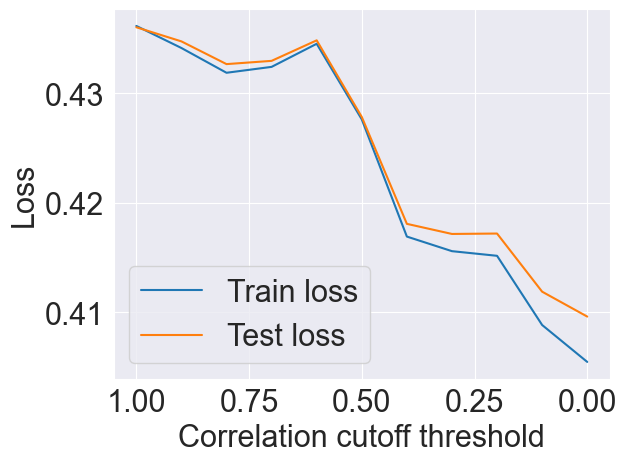

In [102]:
plt.rcParams.update({'font.size': 22})

plt.figure()
ax = sns.lineplot(x=co_linear_thresholds, y=np.array(train_losses), legend='brief', label='Train loss')
sns.lineplot(x=co_linear_thresholds, y=np.array(test_losses), legend='brief', label='Test loss', ax=ax)
ax.invert_xaxis()
#ax.set(title='Line plot showing loss for logistic regression with features\nof interaction terms for different correlation cut-off thresholds', xlabel='Correlation cutoff threshold', ylabel='Loss')
ax.set(xlabel='Correlation cutoff threshold', ylabel='Loss')
plt.savefig( '../data/exp0.png', dpi=500, bbox_inches='tight')
plt.show()

In [87]:
print('Raw data:')
print(co_linear_thresholds)
print([round(train_loss.item(), 2) for train_loss in train_losses])
print([round(test_loss.item(), 2) for test_loss in test_losses])

Raw data:
[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
[0.44, 0.43, 0.43, 0.43, 0.43, 0.43, 0.42, 0.42, 0.42, 0.41, 0.41]
[0.44, 0.43, 0.43, 0.43, 0.43, 0.43, 0.42, 0.42, 0.42, 0.41, 0.41]


In [36]:
# The best performing model's features
co_linear_feature_columns = get_interaction_terms_columns(X_train_public, co_linear_threshold=0.05)
print('We have found', len(co_linear_feature_columns), 'interaction terms with at least that correlation')
X_train = add_interaction_terms_columns(X_train, co_linear_feature_columns)
X_test = add_interaction_terms_columns(X_test, co_linear_feature_columns)

# Train three logistic regression models

w_gd, _, losses_1 = reg_logistic_regression(Y_train, X_train, lambda_=0, initial_w=np.zeros(shape=(X_train.shape[1], 1)), max_iters=max_iterations, gamma=gamma, return_all_losses=True)
w_agdr_0, _, losses_2 = reg_logistic_regression_AGDR(Y_train, X_train, lambda_=0, initial_w=np.zeros(shape=(X_train.shape[1], 1)), max_iters=max_iterations, gamma=gamma, return_all_losses=True)
w_agdr_1, _, losses_3 = reg_logistic_regression_AGDR(Y_train, X_train, lambda_=10E-3, initial_w=np.zeros(shape=(X_train.shape[1], 1)), max_iters=max_iterations, gamma=gamma, return_all_losses=True)

We have found 235 interaction terms with at least that correlation


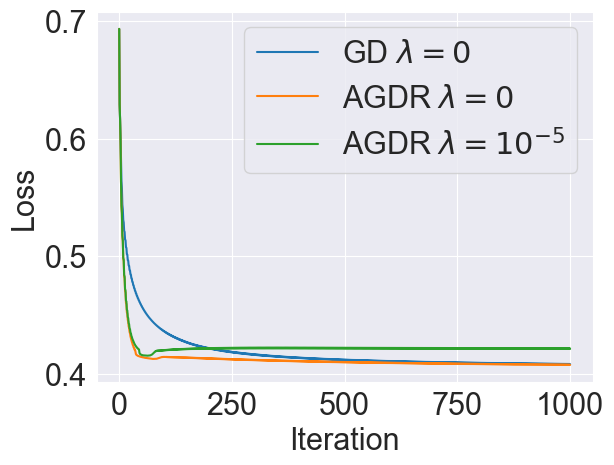

In [100]:
iters = np.arange(max_iterations+1)

plt.figure()
ax = sns.lineplot(x=iters, y=np.array(losses_1), legend='brief', label='GD $\lambda = 0$')
sns.lineplot(x=iters, y=np.array(losses_2), legend='brief', label='AGDR $\lambda = 0$', ax=ax)
sns.lineplot(x=iters, y=np.array(losses_3), legend='brief', label='AGDR $\lambda = 10^{-5}$', ax=ax)
#ax.set(title='Line plot showing change in loss for different algorithms during training', xlabel='Iteration', ylabel='Loss')
ax.set(xlabel='Iteration', ylabel='Loss')
plt.savefig( '../data/exp1.png', dpi=500, bbox_inches='tight')
plt.show()

In [93]:
# Now we can evaluate the training
# ! We can actually also do some hyperparameter tuning (using ROC curves to determine the right cut-off probability) !

# Note ROC curves do not work well for linear regression, since there could be values that are not between 0 and 1!
# In this temporary example I just clip the predictions between 0 and 1

methods = [w_gd, w_agdr_0, w_agdr_1]

print(LogisticRegressionLoss.loss(X_test, Y_test, w_agdr_0))

num_values = 20
cutoff_values = [(i+1)/num_values for i in range(num_values-1)]

for i, w in enumerate(methods):
    accuracies = []
    f1_scores = []

    for cutoff_value in cutoff_values:
        predictions = (LogisticRegressionLoss.sigmoid(X_test @ w) > cutoff_value).astype(np.int32)
        _, _, _, _, accuracy, _, _, f1_score, _ = confusion_matrix_statistics(predictions, Y_test)
        accuracies.append(accuracy)
        f1_scores.append(f1_score)

    best_accuracy, best_accuracy_cutoff, best_acc_f1 = np.max(accuracies), cutoff_values[np.argmax(accuracies)], f1_scores[np.argmax(accuracies)]
    best_f1_score, best_f1_score_cutoff, best_f1_acc = np.max(f1_scores), cutoff_values[np.argmax(f1_scores)], accuracies[np.argmax(f1_scores)]

    print('Method', i+1, ':')
    print('\tBest accuracy / cutoff / F1-score:', best_accuracy, best_accuracy_cutoff, best_acc_f1)
    print('\tBest F1-score / cutoff/ accuracy: ', best_f1_score, best_f1_score_cutoff, best_f1_acc)

0.41074482799786716
Method 1 :
	Best accuracy / cutoff / F1-score: 0.8172666666666667 0.5 0.7263979557205884
	Best F1-score / cutoff/ accuracy:  0.7386737057587673 0.4 0.80596
Method 2 :
	Best accuracy / cutoff / F1-score: 0.8174266666666666 0.5 0.726844740569331
	Best F1-score / cutoff/ accuracy:  0.7388095879342849 0.4 0.80604
Method 3 :
	Best accuracy / cutoff / F1-score: 0.8129466666666667 0.5 0.7170374553742512
	Best F1-score / cutoff/ accuracy:  0.733709339860239 0.4 0.7998133333333334


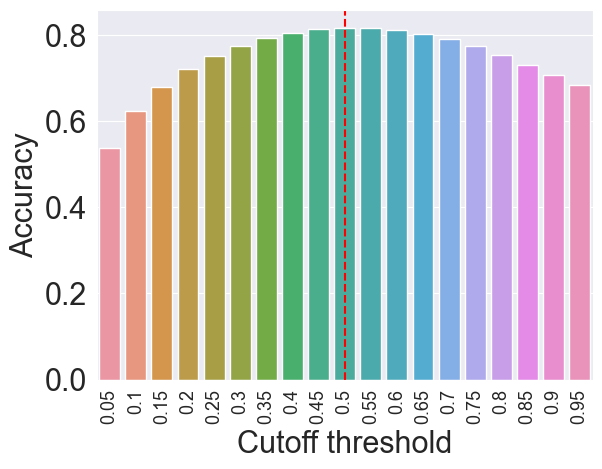

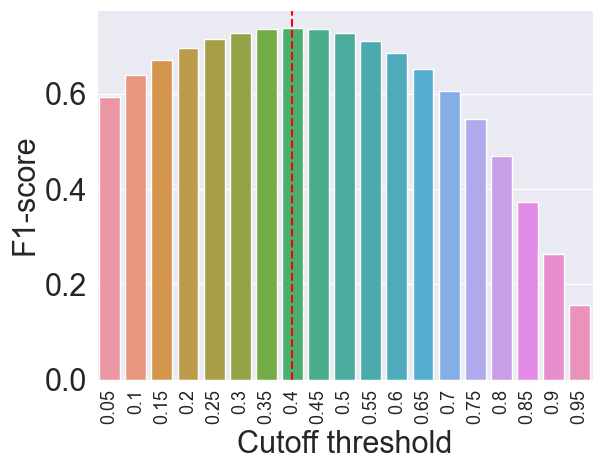

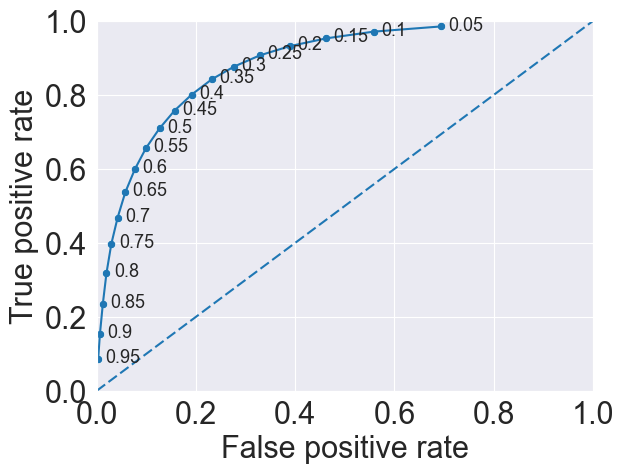

In [124]:
w_best = w_agdr_0

num_values = 20
cutoff_values = [round((i+1)/num_values, 2) for i in range(num_values-1)]

accuracies = []
f1_scores = []
tprs = []
fprs = []

for cutoff_value in cutoff_values:
    predictions = (LogisticRegressionLoss.sigmoid(X_test @ w_best) > cutoff_value).astype(np.int32)
    tp, fp, fn, tn, accuracy, tpr, _, f1_score, fpr = confusion_matrix_statistics(predictions, Y_test)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    tprs.append(tpr)
    fprs.append(fpr)

plt.figure()
ax = sns.barplot(x=cutoff_values, y=accuracies)
largest_idx = np.argmax(accuracies)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
#ax.set(title='Bar chart showing accuracies over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='Accuracy')
ax.set(xlabel='Cutoff threshold', ylabel='Accuracy')
plt.xticks(fontsize=13, rotation=90)
plt.savefig( '../data/exp2.png', dpi=500, bbox_inches='tight')
plt.show()

plt.figure()
largest_idx = np.argmax(f1_scores)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax = sns.barplot(x=cutoff_values, y=f1_scores)
#ax.set(title='Bar chart showing F1-scores over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='F1-score')
ax.set(xlabel='Cutoff threshold', ylabel='F1-score')
plt.xticks(fontsize=13, rotation=90)
plt.savefig( '../data/exp3.png', dpi=500, bbox_inches='tight')
plt.show()

plt.figure()
ax = sns.lineplot(x=fprs, y=tprs, legend=False)
sns.scatterplot(x=fprs, y=tprs, legend=False, ax=ax)
#ax.set(title='ROC curve for classifier over different cutoff thresholds', xlabel='False positive rate', ylabel='True positive rate', xlim=(0, 1), ylim=(0, 1))
ax.set(xlabel='False positive rate', ylabel='True positive rate', xlim=(0, 1), ylim=(0, 1))
ax.axline((0, 0), slope=1, dashes=(5, 2))
for i in range(len(tprs)):
    if i % math.ceil(0.05*len(cutoff_values)) == 0:
        plt.text(x=fprs[i]+0.015,y=tprs[i]-0.01, s=str(round(cutoff_values[i], 2)), fontsize=13)
plt.savefig( '../data/exp4.png', dpi=500, bbox_inches='tight')
plt.show()

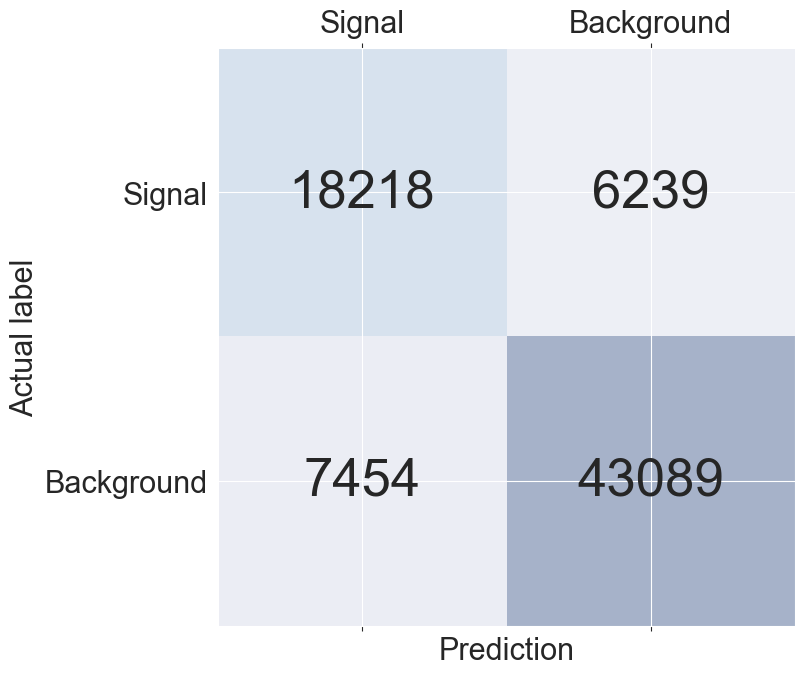

In [142]:
cutoff_value = 0.5
predictions = (LogisticRegressionLoss.sigmoid(X_test @ w_best) > cutoff_value).astype(np.int32)
tp, fp, fn, tn, _, _, _, _, _ = confusion_matrix_statistics(predictions, Y_test)
conf_matrix = np.array([[tp, fp], [fn, tn]])

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

alpha = ['Signal', 'Background']
xaxis = np.arange(len(alpha))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(alpha)
ax.set_yticklabels(alpha)

plt.xlabel('Prediction', fontsize=22)
plt.ylabel('Actual label', fontsize=22)

plt.savefig( '../data/exp5.png', dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
# Testing linear regression
from implementations import ridge_regression

X_train, X_test, Y_train, Y_test = train_test_split(X_train_public, Y_train_public, train_proportion=0.5)

w, loss = ridge_regression(Y_train, X_train, lambda_=0)

# Do predictions with cutoff of 0.5
predictions = X_test @ w
cutoff = 0.5
predictions = (predictions > cutoff).astype(np.int32)
# Mean 0-1 loss
test_loss = np.sum(np.abs(Y_test - predictions)) / Y_test.shape[0]

combined = np.append(Y_test, predictions, axis=0)
n_signal = np.sum(Y_test)
n_background = Y_test.shape[0] - n_signal
correct_predictions_signal = np.sum(predictions * Y_test)
correct_predictions_background = np.sum((predictions + Y_test) == 0)
wrong_predictions_signal = n_signal - correct_predictions_signal
wrong_predictions_background = n_background - correct_predictions_background
print(f'''
Test loss / Mean 0-1 loss: {test_loss},
Number of signal entries: {n_signal},
Number of background entries: {n_background}
Correct predictions of signal: {correct_predictions_signal},
Correct predictions of background: {correct_predictions_background}
Signals correctly predicted: {float(correct_predictions_signal) / n_signal}
Backgrounds correctly predicted: {float(correct_predictions_background) / n_background}
''')


The mean 0-1 loss can be interpreted as the probability of making a wrong classification using linear regression. Setting the cutoff rate manually to 0.5, we observe an 25% probability of making a wrong prediction. The signals are predicted correctly in 87% of the cases, but the background only in 50% of the cases. This can be due to the relative frequency of the cases in the dataset. The effect can be tried out by equalizing the number of the signal and background entries in the data set.

Further tasks:
- Equalize the size of the signal and the background rows in the training (and possibly testing) datasets
- Experiment with different cutoff rates to see if they improve the classification result

In [ ]:
n_cutoff = 20
cutoff_values = np.round_(np.linspace(0, 1, num=n_cutoff, endpoint=False),2)

accuracies = []
f1_scores = []
tprs = []
fprs = []

for cutoff_value in cutoff_values:
    predictions = (X_test @ w > cutoff_value).astype(np.int32)
    tp, fp, fn, tn, accuracy, tpr, _, f1_score, fpr = confusion_matrix_statistics(predictions, Y_test)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    tprs.append(tpr)
    fprs.append(fpr)


plt.figure()
ax = sns.barplot(x=cutoff_values, y=accuracies)
largest_idx = np.argmax(accuracies)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax.set(title='Bar chart showing accuracies over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='Accuracy')
plt.show()

plt.figure()
largest_idx = np.argmax(f1_scores)
plt.axvline(x=largest_idx, ymin=0, ymax=1, linestyle='dashed', color='red')
ax = sns.barplot(x=cutoff_values, y=f1_scores)
ax.set(title='Bar chart showing F1-scores over different cutoff thresholds', xlabel='Cutoff threshold', ylabel='F1-score')
plt.show()

plt.figure()
ax = sns.lineplot(x=fprs, y=tprs, legend=False)
ax.set(title='ROC curve for classifier over different cutoff thresholds', xlabel='False positive rate', ylabel='True positive rate', xlim=(0, 1), ylim=(0, 1))
ax.axline((0, 0), slope=1, dashes=(5, 2))
for i in range(len(tprs)):
    if i % math.ceil(0.05*len(cutoff_values)) == 0:
        plt.text(x=fprs[i]+0.015,y=tprs[i]-0.01, s=str(round(cutoff_values[i], 2)))
plt.show()

0.55 seems to be the optimal cutoff threshold for accuracy.

0.45 seems to be the optimal cutoff threshold for F1-score.

0.5 seems to be a sweet spot with respect to both of them.

In [ ]:
# Create predictions with linear regression
predictions = X_test_public @ w
cutoff = 0.5
predictions = (predictions > cutoff).astype(np.int32)
n_test = X_test_public.shape[0]
n_signal = predictions[predictions == 1].shape[0]
n_background = predictions[predictions == 0].shape[0]
print(f"""Signal in: {n_signal} cases ({n_signal / n_test * 100}%),
Background in {n_background} cases({ n_background / n_test * 100}%),
In total {X_test_public.shape[0]} data points""")

submission_file_name = 'submission_linregr.csv'
with open(os.path.join(data_directory, submission_file_name), mode='w', newline='', encoding='utf-8') as submission_file:
    writer = csv.writer(submission_file, delimiter=',')
    writer.writerow(['Id', 'Prediction'])
    for i, prediction in enumerate(predictions):
        writer.writerow([ids_test_public[i], 1 if prediction else -1])


In [ ]:
def plot_train_test(train_errors, test_errors, lambdas):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression results")
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)

In [ ]:
# Evaluating Ridge regression
from metrics import (
    RidgeLoss
)

def test_ridge_regression(x, y, ratio):
    
    lambdas = np.logspace(-5, 0, 15)
    x_tr, x_te, y_tr, y_te = train_test_split(x, y, train_proportion=ratio)
    rmse_tr = []
    rmse_te = []

    for ind, lambda_ in enumerate(lambdas):
        w, loss = ridge_regression(y_tr, x_tr, lambda_)
        rmse_tr.append(np.sqrt(loss))
        rmse_te.append(np.sqrt(RidgeLoss.loss(x_te, y_te, w)))
    
    plot_train_test(rmse_tr, rmse_te, lambdas)

test_ridge_regression(X_train_public, Y_train_public, 0.5)

For ridge regression the regularization does not seem to improve the test error. Thus, for ridge regression, using the standard linear regression is best for classification.

# Benchmarking

In [ ]:
# Method for benchmarking a certain algorithm (replace algorithm to make it work for other ones)

num_times_training = 10
cutoff_value = 0.5

co_linear_feature_columns = get_interaction_terms_columns(X_train_public, co_linear_threshold=0.05)
print('We have found', len(co_linear_feature_columns), 'interaction terms with at least that correlation')
X_train_public = add_interaction_terms_columns(X_train_public, co_linear_feature_columns)

test_accs = []
test_f1s = []
for i in range(num_times_training):
    X_train, X_test, Y_train, Y_test = train_test_split(X_train_public, Y_train_public, train_proportion=0.8)

    w, _ = reg_logistic_regression(Y_train, X_train, lambda_=0, initial_w=np.zeros((X_train.shape[-1], 1)), max_iters=200, gamma=0.1)

    predictions = (X_test @ w > cutoff_value).astype(np.int32)
    _, _, _ , _, accuracy, _, _, f1_score, _ = confusion_matrix_statistics(predictions, Y_test)

    test_accs.append(accuracy)
    test_f1s.append(f1_score)

We have found 235 interaction terms with at least that correlation
(250000, 268)


 71%|███████   | 142/200 [00:34<00:12,  4.49it/s]

In [35]:
avg = np.mean(test_accs)
print('Accuracy')
print('Average:', round(avg, 3))
print('Maximum deviation:', round(max(avg - np.min(test_accs), np.max(test_accs) - avg), 3))

print('\nF1-Score')
avg = np.mean(test_f1s)
print('Average:', round(avg, 3))
print('Maximum deviation:', round(max(avg - np.min(test_f1s), np.max(test_f1s) - avg), 3))

Accuracy
Average: 0.726
Maximum deviation: 0.003

F1-Score
Average: 0.453
Maximum deviation: 0.006


# Inference

In [ ]:
# Placeholder, array with True of False whether it belongs to the positive or negative sample
best_cutoff = 0.5
w_best = w_agdr_0

predictions = (LogisticRegressionLoss.sigmoid(X_test_public @ w_best) > best_cutoff).astype(np.int32)

submission_file_name = 'submission_sqrt_0.csv'
with open(os.path.join(data_directory, submission_file_name), mode='w', newline='', encoding='utf-8') as submission_file:
    writer = csv.writer(submission_file, delimiter=',')
    writer.writerow(['Id', 'Prediction'])
    for i, prediction in enumerate(predictions):
        writer.writerow([ids_test_public[i], 1 if prediction else -1])
